# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [178]:
import pandas as pd    
df = pd.read_csv('persons_pics_train.csv')
# df.sort_values(by=['label'], inplace=True)
# df.head()
print(df)
# df[['label','0']]

             0         1         2         3         4         5         6  \
0     0.379085  0.312418  0.352941  0.445752  0.466667  0.473203  0.484967   
1     0.450980  0.466667  0.512418  0.509804  0.450980  0.458824  0.516340   
2     0.589542  0.614379  0.688889  0.729412  0.738562  0.775163  0.789543   
3     0.390850  0.432680  0.499346  0.562091  0.597386  0.644444  0.670588   
4     0.645752  0.626144  0.605229  0.585621  0.602614  0.664052  0.701961   
...        ...       ...       ...       ...       ...       ...       ...   
1321  0.237908  0.273203  0.244444  0.332026  0.590850  0.675817  0.684967   
1322  0.105882  0.087582  0.117647  0.260131  0.385621  0.466667  0.566013   
1323  0.322876  0.345098  0.369935  0.375163  0.405229  0.464052  0.494118   
1324  0.304575  0.290196  0.366013  0.444444  0.456209  0.465359  0.479739   
1325  0.190850  0.190850  0.198693  0.184314  0.190850  0.218301  0.253595   

             7         8         9  ...      2905      2906    

Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [179]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

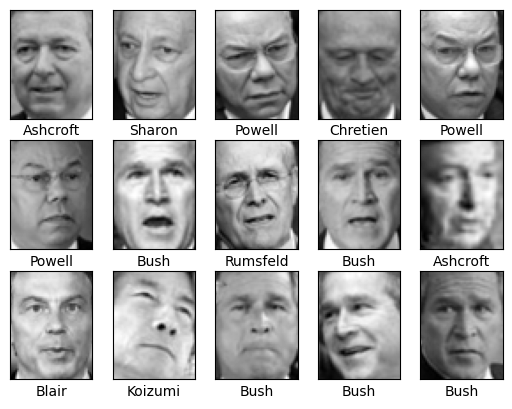

In [180]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

Крупнее

(-0.5, 46.5, 61.5, -0.5)

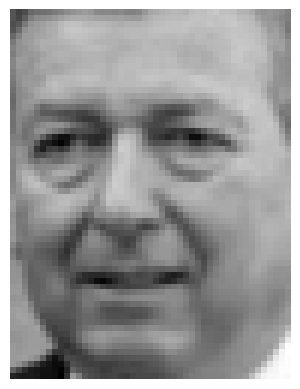

In [181]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [182]:
# < ENTER YOUR CODE HERE > 
df.nunique ()

0        548
1        552
2        557
3        557
4        582
        ... 
2910     696
2911     684
2912     661
2913     656
label     12
Length: 2915, dtype: int64

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

In [183]:
# < ENTER YOUR CODE HERE > 
df['label'].value_counts()

label
George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Serena Williams       44
Jacques Chirac        44
Name: count, dtype: int64

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [184]:
# < ENTER YOUR CODE HERE > 
# Группируем данные по человеку и вычисляем средний вектор
average_vectors = df.groupby('label').mean().reset_index()

# # Вначале удаляем столбец 'label'
# label = average_vectors['label']
# average_vectors = average_vectors.drop('label', axis=1)
# average_vectors['label'] = label
# average_vectors

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [185]:
# < ENTER YOUR CODE HERE > 
average_vectors[['label','0']]

,label,0
0,Ariel Sharon,0.501398
1,Colin Powell,0.433512
2,Donald Rumsfeld,0.404810
3,George W Bush,0.348179
4,Gerhard Schroeder,0.210162
5,Hugo Chavez,0.206885
6,Jacques Chirac,0.348010
7,Jean Chretien,0.388958
8,John Ashcroft,0.337894
9,Junichiro Koizumi,0.268384


Используя усредненные векторы, постройте изображения всех людей из набора данных.

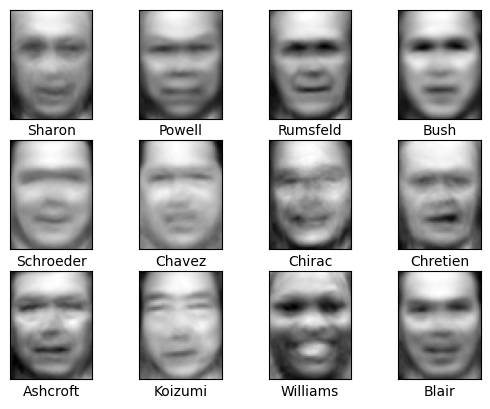

In [186]:
# < ENTER YOUR CODE HERE > 
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(average_vectors.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

[0.99317214 0.99513082 0.99515232 0.99622325 0.99722896 0.99518468
 1.         0.99334977 0.99617187 0.9947458  0.98347907 0.99628436]


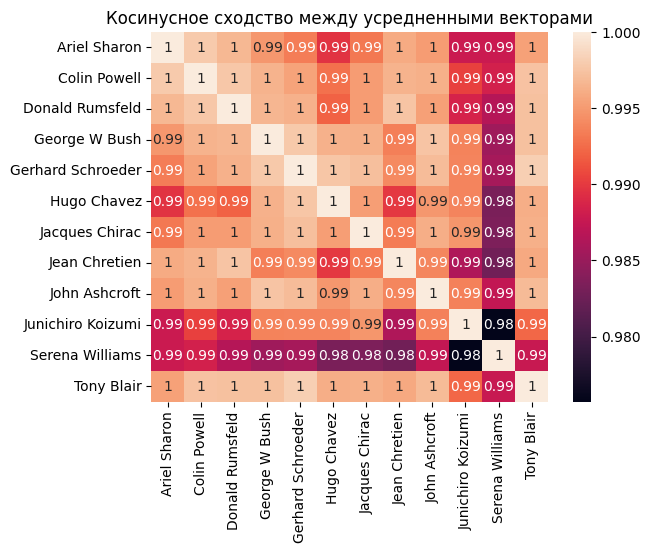

In [187]:
# < ENTER YOUR CODE HERE > 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

average_vectors = df.groupby('label').mean().reset_index()
cosine_sim = cosine_similarity(average_vectors.iloc[:, 1:].values)
print(cosine_sim[6])

sns.heatmap(cosine_sim, annot=True, xticklabels=average_vectors['label'], yticklabels=average_vectors['label'])
plt.title('Косинусное сходство между усредненными векторами')
plt.show()

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [188]:
# < ENTER YOUR CODE HERE > 
# смотри выше

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [190]:
# < ENTER YOUR CODE HERE > 
from sklearn.model_selection import train_test_split
df = pd.read_csv('persons_pics_train.csv')
# df.head()
train_num_x_s,test_num_x_s,train_num_y,test_num_y = train_test_split(df.drop(['label'],axis=1), df['label'], test_size=0.2, random_state=11, stratify=df['label'])


## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [192]:
# < ENTER YOUR CODE HERE > 
from sklearn.svm import SVC
from sklearn.metrics import f1_score

model = SVC(kernel='linear', random_state=11)
model.fit(train_num_x_s, train_num_y)

y_pred = model.predict(test_num_x_s)

f1 = f1_score(test_num_y, y_pred, average='weighted')
print(len(test_num_y))
print(len(y_pred))

print("F1-мера со средним значением по весам:", f1)


266
266
F1-мера со средним значением по весам: 0.7838258158689967


Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE > 
# смотри выше

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [112]:
# < ENTER YOUR CODE HERE > 

from sklearn.model_selection import GridSearchCV

# Задайте параметры для настройки
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]

# Создайте объект GridSearchCV
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

# Запустите настройку гиперпараметров
cv.fit(train_num_x_s, train_num_y)

# Получите лучшую модель
best_model = cv.best_estimator_

# Выведите лучшие гиперпараметры
print("Лучшие гиперпараметры:")
print(cv.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.807 total time=   0.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.792 total time=   0.4s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.769 total time=   0.4s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.797 total time=   0.4s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.764 total time=   0.4s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.349 total time=   0.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.358 total time=   0.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.368 total time=   0.6s
[CV 4/5] END C=1, class_weight=N

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 
# смотри выше

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [177]:
# < ENTER YOUR CODE HERE > 
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# 'C': 100, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 11
model = SVC(C=100, class_weight='balanced', gamma=0.001,  kernel='rbf', random_state=11)
model.fit(train_num_x_s, train_num_y)

y_pred = model.predict(test_num_x_s)

f1 = f1_score(test_num_y, y_pred, average='weighted')
print("F1-мера со средним значением по весам:", f1)

InvalidParameterError: The 'y_true' parameter of f1_score must be an array-like or a sparse matrix. Got 0 instead.

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [122]:
# < ENTER YOUR CODE HERE > 
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Создайте объект PCA
pca = PCA(svd_solver='full')

# Определите минимальное количество компонент для объясненной дисперсии > 0,95
n_components = 0
explained_variance_ratio_sum = 0
while explained_variance_ratio_sum < 0.95:
    n_components += 1
    pca.n_components = n_components
    pca.fit(train_num_x_s)
    explained_variance_ratio_sum = sum(pca.explained_variance_ratio_)

# Обучите модель PCA с минимальным количеством компонент
pca.n_components = n_components
pca.fit(train_num_x_s)

# Выведите требуемое количество главных компонент
print("Требуемое число главных компонент:", n_components)

Требуемое число главных компонент: 172


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [123]:
# < ENTER YOUR CODE HERE > 
import time

pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(train_num_x_s)

# Преобразуйте тренировочные и тестовые данные с помощью PCA
X_train_pca = pca.transform(train_num_x_s)
X_test_pca = pca.transform(test_num_x_s)

# Задайте параметры для настройки
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]

# Создайте объект GridSearchCV
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

# Запустите настройку гиперпараметров
start_time = time.time()
cv.fit(X_train_pca, train_num_y)
end_time = time.time()

# Получите лучшую модель
best_model = cv.best_estimator_

# Выведите время обучения
print("Время обучения:", end_time - start_time)

# Выведите лучшие гиперпараметры
print("Лучшие гиперпараметры:")
print(cv.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.788 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.783 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.722 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.783 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.717 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.340 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.344 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.340 total time=   0.0s
[CV 4/5] END C=1, class_weight=N

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [193]:
# < ENTER YOUR CODE HERE > 
# Сделайте предсказания для тестовых данных
# y_pred = best_model.predict(X_test_pca)

# # Вычислите F1-оценку
# f1 = f1_score(test_num_y, y_pred, average='weighted')

# # Выведите F1-оценку
# print("F1-оценка:", f1)

import pandas as pd    
df = pd.read_csv('persons_pics_train.csv')
train_num_x_s = df.drop(['label'],axis=1)
train_num_y = df['label']
print(len(train_num_x_s))
print(len(train_num_y))

df_new = pd.read_csv('persons_pics_reserved.csv')
df_new['label'] = '0'
test_num_x_s = df_new.drop(['label'],axis=1)
print(len(test_num_x_s))

model = SVC(C=100, class_weight='balanced', gamma=0.001,  kernel='rbf', random_state=11)
model.fit(train_num_x_s, train_num_y)

y_pred = model.predict(test_num_x_s)
print(len(y_pred))
file1 = open("MyFile.txt", "w")
file1.write(str(y_pred))
file1.close() 

# f1 = f1_score(train_num_y, y_pred, average='weighted')
# print("F1-мера со средним значением по весам:", f1)

1326
1326
234
234


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.